In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import csv as csv
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew
from collections import OrderedDict

In [3]:
train_dataset = pd.read_csv('./train.csv')
test_dataset = pd.read_csv('./test.csv')

In [4]:
print(train_dataset.columns.tolist())

['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC'

In [5]:
categorical_features=['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities',
                      'LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle',
                      'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond',
                      'Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating',
                      'HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu',
                     'GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence',
                     'MiscFeature','SaleType','SaleCondition']
every_column_except_y= [col for col in train_dataset.columns if col not in ['SalePrice','Id']]
train_dataset.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Preparing Dataset

#### Normalizing

In [6]:
every_column_non_categorical = [
    col for col in train_dataset.columns 
    if col not in categorical_features and col not in ['Id']
    ]

numeric_feats = train_dataset[every_column_non_categorical].dtypes[train_dataset.dtypes != "object"].index

train_dataset[numeric_feats] = np.log1p(train_dataset[numeric_feats])

every_column_non_categorical = [
    col for col in test_dataset.columns 
    if col not in categorical_features and col not in ['Id']
    ]
numeric_feats = test_dataset[every_column_non_categorical].dtypes[test_dataset.dtypes != 'object'].index
test_dataset[numeric_feats] = np.log1p(test_dataset[numeric_feats])

#### Cleaning

In [7]:
nan_columns = train_dataset.columns[train_dataset.isna().any()].tolist()
print(nan_columns)

['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


In [8]:
features_with_nan=['Alley','MasVnrType','BsmtQual','BsmtQual','BsmtCond','BsmtCond','BsmtExposure',
                   'BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType','GarageFinish']
# features_with_nan = nan_columns

def ConverNaNToNAString(data, columnlist):
    for x in columnlist:
        data[x] = str(data[x])

ConverNaNToNAString(train_dataset, features_with_nan)
ConverNaNToNAString(test_dataset, features_with_nan)

#### Creating column from each categorical features value

In [9]:
def CreateColumnPerValue(data, columnList):
    for x in columnList:

        values = pd.unique(data[x])

        for v in values:
            column_name=x+'_'+str(v)
            data[column_name]=(data[x]==v).astype(float)

        data.drop(x, axis=1, inplace=True)

In [10]:
train_dataset = pd.get_dummies(train_dataset, columns= categorical_features)
test_dataset = pd.get_dummies(test_dataset, columns= categorical_features)

#### Looking for most relevant features

In [11]:
model = xgb.XGBRegressor(colsample_bytree=0.4,
                         gamma=0,
                         learning_rate=0.07, 
                         max_depth=3,
                         min_child_weight=1.5,
                         n_estimators=10000,
                         reg_lambda=0.45,
                         subsample=0.6,
                         seed=42,
                         )

In [12]:
every_column_except_y = [
    col for col in train_dataset.columns
    if col not in ['SalePrice']
    ]

X = train_dataset[every_column_except_y]
y = train_dataset['SalePrice']

model.fit(X, y)

OrderedDict(sorted(model.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True, ), )
# importance = model.feature_importances_
# print(importance)

# variable_importance_metrics = 'NUM_AS_ROOT'
# variable_importance = importance.variable_importance()[variable_importance_metrics]

# features_name = [vi[0].name for vi in variable_importance]
# features_importance = [vi[1] for vi in variable_importance]
# features_rank = range(len(features_name))

# bar = plt.barh(features_rank, features_importance, label=[str(x) for x in features_rank], c='orangered')
# plt.yticks(features_rank, features_name)
# plt.gca().invert_yaxis()

# for importance, patch in zip(features_importance, bar.patches):
#     plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f'{importance}:.4f', va='top')

# plt.xlabel(variable_importance_metrics)
# plt.title('NUM AS ROOT of the class 1 vs the others')
# plt.tight_layout()
# plt.show()

c:\Users\Hammam\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Hammam\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\Hammam\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\Hammam\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
c:\Users\Hammam\Lib\site-packages\xgb

OrderedDict([('Id', 3159.0),
             ('LotArea', 3057.0),
             ('BsmtUnfSF', 2901.0),
             ('LotFrontage', 2683.0),
             ('GrLivArea', 2563.0),
             ('1stFlrSF', 2214.0),
             ('TotalBsmtSF', 2120.0),
             ('GarageArea', 2083.0),
             ('BsmtFinSF1', 2045.0),
             ('GarageYrBlt', 2030.0),
             ('YearBuilt', 1731.0),
             ('MasVnrArea', 1720.0),
             ('YearRemodAdd', 1409.0),
             ('OpenPorchSF', 1409.0),
             ('MoSold', 1338.0),
             ('WoodDeckSF', 1298.0),
             ('2ndFlrSF', 1140.0),
             ('YrSold', 808.0),
             ('TotRmsAbvGrd', 763.0),
             ('OverallQual', 591.0),
             ('BsmtFinSF2', 504.0),
             ('OverallCond', 449.0),
             ('Neighborhood_CollgCr', 388.0),
             ('EnclosedPorch', 361.0),
             ('Fireplaces', 350.0),
             ('BedroomAbvGr', 291.0),
             ('ScreenPorch', 234.0),
           

In [13]:
most_relevant_features = list(dict((k, v) for k, v in model.get_booster().get_fscore().items() if v >= 10).keys())
print(most_relevant_features)

['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120', 'MSSubClass_160', 'MSSubClass_190', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotC

#### Analyzing most importance fatures

C:\Users\Hammam\AppData\Local\Temp\ipykernel_2128\1903546517.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


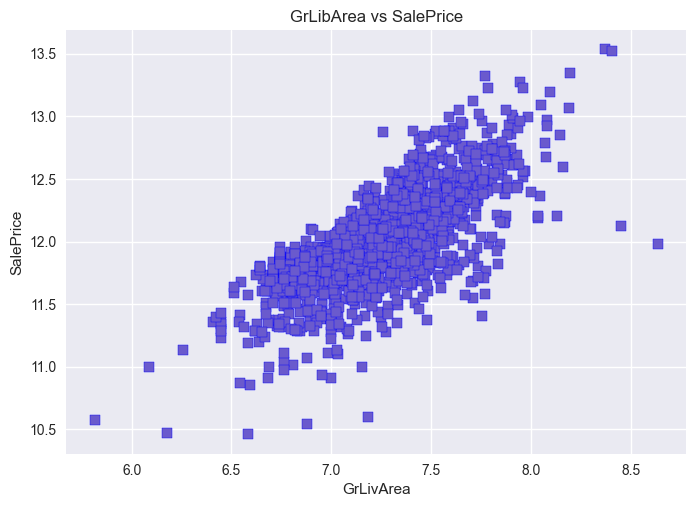

In [14]:
# most_relevant_features= list( dict((k, v) for k, v in model.booster().get_fscore().items() if v >= 10).keys())
# print(most_relevant_features)
plt.style.use('seaborn')

plt.scatter(train_dataset.GrLivArea, train_dataset.SalePrice, c='slateblue', marker='s', edgecolors='blue')
plt.title('GrLibArea vs SalePrice')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

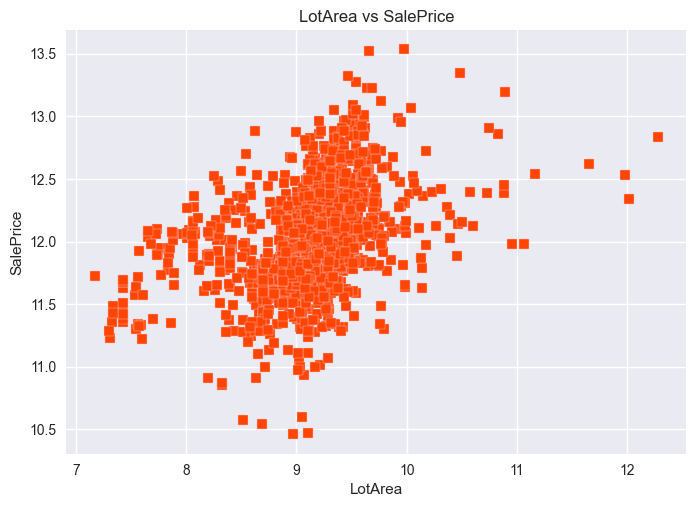

In [15]:
plt.scatter(train_dataset.LotArea, train_dataset.SalePrice, c='orangered', marker= 's', edgecolors='pink')
plt.title('LotArea vs SalePrice')
plt.xlabel('LotArea')
plt.ylabel('SalePrice')
plt.show()

In [16]:
train_dataset = train_dataset[train_dataset.GrLivArea < 8.25]
train_dataset = train_dataset[train_dataset.LotArea < 11.5]
train_dataset = train_dataset[train_dataset.SalePrice<13]
train_dataset = train_dataset[train_dataset.SalePrice>10.75]
# train_dataset.drop('Id', axis=1, inplace=True)
train_dataset.head()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,4.189655,9.042040,2.079442,1.791759,7.602900,7.602900,5.283204,6.561031,0.0,...,False,False,False,True,False,False,False,False,True,False
1,2,4.394449,9.169623,1.945910,2.197225,7.589336,7.589336,0.000000,6.886532,0.0,...,False,False,False,True,False,False,False,False,True,False
2,3,4.234107,9.328212,2.079442,1.791759,7.601902,7.602401,5.093750,6.188264,0.0,...,False,False,False,True,False,False,False,False,True,False
3,4,4.110874,9.164401,2.079442,1.791759,7.557995,7.586296,0.000000,5.379897,0.0,...,False,False,False,True,True,False,False,False,False,False
4,5,4.442651,9.565284,2.197225,1.791759,7.601402,7.601402,5.860786,6.486161,0.0,...,False,False,False,True,False,False,False,False,True,False


#### Calculating best metaparameters

In [17]:
train_x = train_dataset[most_relevant_features]
train_y = train_dataset['SalePrice']

best_xgb_model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)
best_xgb_model.fit(train_x,train_y)

c:\Users\Hammam\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Hammam\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\Hammam\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\Hammam\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
c:\Users\Hammam\Lib\site-packages\xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.07, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1.5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt



In [24]:
# test_x = train_dataset[most_relevant_features]
# test_y = train_dataset['SalePrice']
# y_test_pred = model.predict(train_x)

# print(f"MAE : {mean_absolute_error(test_y, y_test_pred)}")
# print(f"MSE : {mean_squared_error(test_y, y_test_pred)}")
# print(f"RMSE : {sqrt(mean_squared_error(test_y, y_test_pred))}")
# print(f"R^2 : {r2_score(train_y, y_test_pred)}")

c:\Users\Hammam\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Hammam\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\Hammam\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\Hammam\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


ValueError: feature_names mismatch: ['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'Alley_0       NaN\n1       NaN\n2       NaN\n3       NaN\n4       NaN\n       ... \n1455    NaN\n1456    NaN\n1457    NaN\n1458    NaN\n1459    NaN\nName: Alley, Length: 1460, dtype: object', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'Utilities_AllPub', 'Utilities_NoSeWa', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr', 'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Fin', 'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'RoofStyle_Flat', 'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_ClyTile', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing', 'Exterior2nd_AsbShng', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd', 'Exterior2nd_Other', 'Exterior2nd_Plywood', 'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'Exterior2nd_Wd Shng', 'MasVnrType_0       BrkFace\n1           NaN\n2       BrkFace\n3           NaN\n4       BrkFace\n         ...   \n1455        NaN\n1456      Stone\n1457        NaN\n1458        NaN\n1459        NaN\nName: MasVnrType, Length: 1460, dtype: object', 'ExterQual_Ex', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'ExterCond_Ex', 'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_Po', 'ExterCond_TA', 'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'BsmtQual_0       0       Gd\\n1       Gd\\n2       Gd\\n3       TA...\n1       0       Gd\\n1       Gd\\n2       Gd\\n3       TA...\n2       0       Gd\\n1       Gd\\n2       Gd\\n3       TA...\n3       0       Gd\\n1       Gd\\n2       Gd\\n3       TA...\n4       0       Gd\\n1       Gd\\n2       Gd\\n3       TA...\n                              ...                        \n1455    0       Gd\\n1       Gd\\n2       Gd\\n3       TA...\n1456    0       Gd\\n1       Gd\\n2       Gd\\n3       TA...\n1457    0       Gd\\n1       Gd\\n2       Gd\\n3       TA...\n1458    0       Gd\\n1       Gd\\n2       Gd\\n3       TA...\n1459    0       Gd\\n1       Gd\\n2       Gd\\n3       TA...\nName: BsmtQual, Length: 1460, dtype: object', 'BsmtCond_0       0       TA\\n1       TA\\n2       TA\\n3       Gd...\n1       0       TA\\n1       TA\\n2       TA\\n3       Gd...\n2       0       TA\\n1       TA\\n2       TA\\n3       Gd...\n3       0       TA\\n1       TA\\n2       TA\\n3       Gd...\n4       0       TA\\n1       TA\\n2       TA\\n3       Gd...\n                              ...                        \n1455    0       TA\\n1       TA\\n2       TA\\n3       Gd...\n1456    0       TA\\n1       TA\\n2       TA\\n3       Gd...\n1457    0       TA\\n1       TA\\n2       TA\\n3       Gd...\n1458    0       TA\\n1       TA\\n2       TA\\n3       Gd...\n1459    0       TA\\n1       TA\\n2       TA\\n3       Gd...\nName: BsmtCond, Length: 1460, dtype: object', 'BsmtExposure_0       No\n1       Gd\n2       Mn\n3       No\n4       Av\n        ..\n1455    No\n1456    No\n1457    No\n1458    Mn\n1459    No\nName: BsmtExposure, Length: 1460, dtype: object', 'BsmtFinType1_0       GLQ\n1       ALQ\n2       GLQ\n3       ALQ\n4       GLQ\n       ... \n1455    Unf\n1456    ALQ\n1457    GLQ\n1458    GLQ\n1459    BLQ\nName: BsmtFinType1, Length: 1460, dtype: object', 'BsmtFinType2_0       Unf\n1       Unf\n2       Unf\n3       Unf\n4       Unf\n       ... \n1455    Unf\n1456    Rec\n1457    Unf\n1458    Rec\n1459    LwQ\nName: BsmtFinType2, Length: 1460, dtype: object', 'Heating_Floor', 'Heating_GasA', 'Heating_GasW', 'Heating_Grav', 'Heating_OthW', 'Heating_Wall', 'HeatingQC_Ex', 'HeatingQC_Fa', 'HeatingQC_Gd', 'HeatingQC_Po', 'HeatingQC_TA', 'CentralAir_N', 'CentralAir_Y', 'Electrical_FuseA', 'Electrical_FuseF', 'Electrical_FuseP', 'Electrical_Mix', 'Electrical_SBrkr', 'KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA', 'Functional_Maj1', 'Functional_Maj2', 'Functional_Min1', 'Functional_Min2', 'Functional_Mod', 'Functional_Sev', 'Functional_Typ', 'FireplaceQu_0       NaN\n1        TA\n2        TA\n3        Gd\n4        TA\n       ... \n1455     TA\n1456     TA\n1457     Gd\n1458    NaN\n1459    NaN\nName: FireplaceQu, Length: 1460, dtype: object', 'GarageType_0       Attchd\n1       Attchd\n2       Attchd\n3       Detchd\n4       Attchd\n         ...  \n1455    Attchd\n1456    Attchd\n1457    Attchd\n1458    Attchd\n1459    Attchd\nName: GarageType, Length: 1460, dtype: object', 'GarageFinish_0       RFn\n1       RFn\n2       RFn\n3       Unf\n4       RFn\n       ... \n1455    RFn\n1456    Unf\n1457    RFn\n1458    Unf\n1459    Fin\nName: GarageFinish, Length: 1460, dtype: object', 'GarageQual_Ex', 'GarageQual_Fa', 'GarageQual_Gd', 'GarageQual_Po', 'GarageQual_TA', 'GarageCond_Ex', 'GarageCond_Fa', 'GarageCond_Gd', 'GarageCond_Po', 'GarageCond_TA', 'PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y', 'PoolQC_Ex', 'PoolQC_Fa', 'PoolQC_Gd', 'Fence_GdPrv', 'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw', 'MiscFeature_Gar2', 'MiscFeature_Othr', 'MiscFeature_Shed', 'MiscFeature_TenC', 'SaleType_COD', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD', 'SaleCondition_Abnorml', 'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal', 'SaleCondition_Partial'] ['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120', 'MSSubClass_160', 'MSSubClass_190', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod', 'Neighborhood_Blmngtn', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition2_Feedr', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Fin', 'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2Story', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'RoofStyle_Flat', 'RoofStyle_Gable', 'RoofStyle_Hip', 'RoofMatl_Tar&Grv', 'Exterior1st_AsbShng', 'Exterior1st_BrkFace', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing', 'Exterior2nd_AsbShng', 'Exterior2nd_BrkFace', 'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd', 'Exterior2nd_Plywood', 'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'Exterior2nd_Wd Shng', 'ExterQual_Ex', 'ExterQual_Gd', 'ExterQual_TA', 'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_TA', 'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Heating_GasA', 'Heating_Wall', 'HeatingQC_Ex', 'HeatingQC_Fa', 'HeatingQC_Gd', 'HeatingQC_TA', 'CentralAir_N', 'CentralAir_Y', 'Electrical_FuseA', 'Electrical_FuseF', 'Electrical_SBrkr', 'KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA', 'Functional_Maj1', 'Functional_Maj2', 'Functional_Min1', 'Functional_Min2', 'Functional_Mod', 'Functional_Typ', 'GarageQual_Fa', 'GarageQual_Gd', 'GarageQual_TA', 'GarageCond_Fa', 'GarageCond_Gd', 'GarageCond_TA', 'PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y', 'Fence_GdPrv', 'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw', 'MiscFeature_Shed', 'SaleType_COD', 'SaleType_CWD', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_WD', 'SaleCondition_Abnorml', 'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal', 'SaleCondition_Partial']
expected HeatingQC_Po, Street_Pave, Heating_Grav, Condition2_Artery, SaleCondition_AdjLand, SaleType_Oth, BsmtQual_0       0       Gd\n1       Gd\n2       Gd\n3       TA...
1       0       Gd\n1       Gd\n2       Gd\n3       TA...
2       0       Gd\n1       Gd\n2       Gd\n3       TA...
3       0       Gd\n1       Gd\n2       Gd\n3       TA...
4       0       Gd\n1       Gd\n2       Gd\n3       TA...
                              ...                        
1455    0       Gd\n1       Gd\n2       Gd\n3       TA...
1456    0       Gd\n1       Gd\n2       Gd\n3       TA...
1457    0       Gd\n1       Gd\n2       Gd\n3       TA...
1458    0       Gd\n1       Gd\n2       Gd\n3       TA...
1459    0       Gd\n1       Gd\n2       Gd\n3       TA...
Name: BsmtQual, Length: 1460, dtype: object, Utilities_NoSeWa, ExterQual_Fa, Condition2_PosN, GarageFinish_0       RFn
1       RFn
2       RFn
3       Unf
4       RFn
       ... 
1455    RFn
1456    Unf
1457    RFn
1458    Unf
1459    Fin
Name: GarageFinish, Length: 1460, dtype: object, Exterior1st_BrkComm, PoolQC_Fa, GarageQual_Ex, Alley_0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
1455    NaN
1456    NaN
1457    NaN
1458    NaN
1459    NaN
Name: Alley, Length: 1460, dtype: object, MSSubClass_180, Utilities_AllPub, GarageCond_Ex, GarageType_0       Attchd
1       Attchd
2       Attchd
3       Detchd
4       Attchd
         ...  
1455    Attchd
1456    Attchd
1457    Attchd
1458    Attchd
1459    Attchd
Name: GarageType, Length: 1460, dtype: object, Electrical_FuseP, FireplaceQu_0       NaN
1        TA
2        TA
3        Gd
4        TA
       ... 
1455     TA
1456     TA
1457     Gd
1458    NaN
1459    NaN
Name: FireplaceQu, Length: 1460, dtype: object, RoofMatl_WdShake, PoolQC_Gd, BsmtFinType2_0       Unf
1       Unf
2       Unf
3       Unf
4       Unf
       ... 
1455    Unf
1456    Rec
1457    Unf
1458    Rec
1459    LwQ
Name: BsmtFinType2, Length: 1460, dtype: object, PoolQC_Ex, RoofMatl_Roll, Foundation_Stone, Street_Grvl, BsmtCond_0       0       TA\n1       TA\n2       TA\n3       Gd...
1       0       TA\n1       TA\n2       TA\n3       Gd...
2       0       TA\n1       TA\n2       TA\n3       Gd...
3       0       TA\n1       TA\n2       TA\n3       Gd...
4       0       TA\n1       TA\n2       TA\n3       Gd...
                              ...                        
1455    0       TA\n1       TA\n2       TA\n3       Gd...
1456    0       TA\n1       TA\n2       TA\n3       Gd...
1457    0       TA\n1       TA\n2       TA\n3       Gd...
1458    0       TA\n1       TA\n2       TA\n3       Gd...
1459    0       TA\n1       TA\n2       TA\n3       Gd...
Name: BsmtCond, Length: 1460, dtype: object, Condition2_PosA, RoofMatl_Metal, Exterior1st_CBlock, Neighborhood_Blueste, Exterior2nd_CBlock, MiscFeature_Othr, Heating_OthW, Condition1_RRNe, BsmtExposure_0       No
1       Gd
2       Mn
3       No
4       Av
        ..
1455    No
1456    No
1457    No
1458    Mn
1459    No
Name: BsmtExposure, Length: 1460, dtype: object, HouseStyle_2.5Fin, BsmtFinType1_0       GLQ
1       ALQ
2       GLQ
3       ALQ
4       GLQ
       ... 
1455    Unf
1456    ALQ
1457    GLQ
1458    GLQ
1459    BLQ
Name: BsmtFinType1, Length: 1460, dtype: object, MasVnrType_0       BrkFace
1           NaN
2       BrkFace
3           NaN
4       BrkFace
         ...   
1455        NaN
1456      Stone
1457        NaN
1458        NaN
1459        NaN
Name: MasVnrType, Length: 1460, dtype: object, Heating_Floor, GarageCond_Po, Condition1_RRNn, Electrical_Mix, ExterCond_Ex, MSSubClass_75, LandSlope_Sev, RoofMatl_CompShg, MSSubClass_40, Heating_GasW, MiscFeature_Gar2, Exterior2nd_Other, RoofMatl_ClyTile, Condition2_RRAn, Exterior1st_AsphShn, HouseStyle_2.5Unf, Exterior2nd_Brk Cmn, Exterior1st_ImStucc, Exterior1st_Stone, ExterCond_Po, RoofStyle_Gambrel, RoofStyle_Mansard, MiscFeature_TenC, Functional_Sev, RoofMatl_Membran, SaleType_Con, Condition2_Norm, RoofMatl_WdShngl, Condition2_RRAe, Foundation_Wood, Condition2_RRNn, GarageQual_Po, RoofStyle_Shed, Exterior2nd_AsphShn in input data

#### Predict for test data and generate submission file

In [22]:
test_dataset['Prediction'] = np.expm1(best_xgb_model.predict(test_dataset[most_relevant_features]))

filename = 'submission.csv'
pd.DataFrame({'Id': test_dataset.Id, 'SalePrice': test_dataset.Prediction}).to_csv(filename, index=False)

c:\Users\Hammam\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Hammam\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\Hammam\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\Hammam\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


In [23]:
print(test_dataset['Prediction'].head())
print(test_dataset['Prediction'].count())

0    120611.289062
1    155228.156250
2    185200.546875
3    195545.359375
4    172323.171875
Name: Prediction, dtype: float32
1459
